# 제주 퇴근시간 버스 승차 인원 예측
1. 배경     
제주도 내 인구는 계송 성장중. 제주 교통체증은 심각한 문제가 되고있음.   
2. 데이터 셋 배경지식
> - 같은 정류장이름이지만 위도, 경도가 서로 다른 경우 존재(=길 건너편 정류장)   
> - 버스카드로 결제한 경우가 승, 하차 데이터로 기록됨. but 버스에서 하차할 때 버스카드를 찍지 않는 경우 기록이 비어있을 수 있음. (승, 하차 인원이 동일하지 않음)  



3. 데이터    
train : 2019년 9월 출퇴근 시간대(오전 6시에서 12시, + 저녁 6시에서 8시)의 **정류장 별** 승하차 인원        
test : 2019년 10월의 출근 시간대(오전 6시에서 12시)의 **정류장 별** 승하차 인원    
bus_bts : **버스카드별** 승하차 정보가 기록됨. (탑승 시간대가 오전 6~12시 사이인 것만 있음.)      
> test데이터의 id의 18시~20시(퇴근시간) 승차 인원 예측     
**(오전의 승차량만 주고 오후의 승차량 예측)**     
**y = 오후의 승차량**
4. 추가 사용 가능     
> * kcb 시각화 대회 제주 금융라이프 데이터
> * 행정동 별 위도 경도 데이터   

### < 칼럼 설명 > 
- bus_route_id : 노선 ID   
- in_out : 시내, 시외버스 구분   
- station_code : 해당 승하차 정류소의 ID   
- station_name : 정류소 이름
- latitude : 위도  
- longitude : 경도(같은 정류장 이름이라도 버스 **방향** 에 따라 다를 수 있음.)   
- X-Y_ride : X:00:00부터 X:59:59까지 승차한 인원 수      
- X-Y_takeoff : X:00:00부터 X:59:59까지 하차한 인원 수      
- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재)  

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv') # 9월 정류장, 시간대별 승차량
test = pd.read_csv('test.csv') # 10월 정류장, 시간대별 승차량
bus = pd.read_csv('bus_bts.csv')
# 제주 우편번호 단위 지역민의 금융생활 통계 데이터. 우편번호별 통계
fin = pd.read_csv('jeju_financial_life_data.csv') 

In [2]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
bus.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

In [5]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_card_id         float64
 1   bus_route_id         int64  
 2   vhc_id               int64  
 3   geton_date           object 
 4   geton_time           object 
 5   geton_station_code   int64  
 6   geton_station_name   object 
 7   getoff_date          object 
 8   getoff_time          object 
 9   getoff_station_code  float64
 10  getoff_station_name  object 
 11  user_category        int64  
 12  user_count           int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


In [6]:
bus.isnull().sum() # 하차 시 버스카드 안찍고 내린 승객들...

user_card_id                0
bus_route_id                0
vhc_id                      0
geton_date                  0
geton_time                  0
geton_station_code          0
geton_station_name         49
getoff_date            895736
getoff_time            895736
getoff_station_code    895736
getoff_station_name    895775
user_category               0
user_count                  0
dtype: int64

In [7]:
print(train.shape, bus.shape)

(415423, 21) (2409414, 13)


In [8]:
print(train['in_out'].value_counts()/len(train)) 
# 시내 버스 비중이 훨씬 높음

시내    0.983335
시외    0.016665
Name: in_out, dtype: float64


In [9]:
train['date'] = pd.to_datetime(train['date'])

In [10]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [11]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride'],
      dtype='object')

#### 정류장별 총 승하차 인원 

In [12]:
train['ride_count'] = train['6~7_ride'] + train['7~8_ride'] + train['8~9_ride'] + train['9~10_ride'] + train['10~11_ride'] + train['11~12_ride']
train['takeoff_count'] = train['6~7_takeoff'] + train['7~8_takeoff'] + train['8~9_takeoff'] + train['9~10_takeoff'] + train['10~11_takeoff'] + train['11~12_takeoff']
train['all_count'] = train['ride_count'] + train['takeoff_count']

In [13]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,ride_count,takeoff_count,all_count
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,16.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,22.0,0.0,22.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,4.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,79.0,0.0,79.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [14]:
# 총 승하차 count의 분포를 보니, 
# 출퇴근 시간대에 사람들이 한번에 내리고 타는 특정 정류장이 있는듯 
train.ride_count.describe()

count    415423.000000
mean          3.772427
std           8.371017
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         368.000000
Name: ride_count, dtype: float64

In [15]:
train.takeoff_count.describe()

count    415423.000000
mean          2.216018
std           5.595708
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         238.000000
Name: takeoff_count, dtype: float64

In [47]:
# 전체 시간대 승차량이 50이상인 정류장 row
ride_50 = train.query('ride_count>50')
ride_50.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,ride_count,takeoff_count,all_count
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.0,79.0,0.0,79.0
223,223,2019-09-01,21180000,시내,149,제주버스터미널,33.49993,126.51486,0.0,4.0,...,0.0,0.0,0.0,0.0,1.0,0.0,17.0,57.0,1.0,58.0
1193,1193,2019-09-01,22520000,시내,1565,시외버스출발지(가상정류소),33.49946,126.51478,20.0,14.0,...,0.0,1.0,0.0,0.0,0.0,0.0,56.0,110.0,1.0,111.0
1227,1227,2019-09-01,22520000,시내,3270,제주시청(아라방면),33.49956,126.52977,21.0,21.0,...,0.0,1.0,3.0,1.0,4.0,1.0,70.0,122.0,10.0,132.0
1240,1240,2019-09-01,22530000,시내,136,산천단한국폴리텍대학,33.44799,126.55558,1.0,11.0,...,1.0,0.0,0.0,0.0,0.0,0.0,21.0,86.0,1.0,87.0


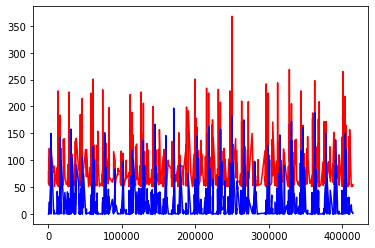

In [55]:
from matplotlib import pyplot as plt
ride_50['ride_count'].plot(color='red')
ride_50['takeoff_count'].plot(color='blue')
# 승차량이 50이상인 열들은 승차량과 하차량이 차이나는 경우가 많다
# 승, 하차량의 차이로 피쳐를 만들어보자!

In [58]:
# 정류장별 승, 하차량의 차이
train['rt_dif'] = train['ride_count']-train['takeoff_count']
# 양수면 승차량이 더 많고, 음수면 하차량이 더 많다!

In [59]:
train['rt_dif'].describe()

count    415423.000000
mean          1.556409
std           8.206711
min        -193.000000
25%          -1.000000
50%           1.000000
75%           3.000000
max         254.000000
Name: rt_dif, dtype: float64

#### 날짜에 따른 승하차량 합

In [17]:
 # series
a = train.groupby('date')['ride_count'].sum()
b = train.groupby('date')['takeoff_count'].sum()
c = train.groupby('date')['all_count'].sum()

date = pd.DataFrame([a,b,c]).transpose()
date = date.rename(columns={'ride_count':'date_ride_count', 'takeoff_count':'date_takeoff_count', 'all_count':'date_all_count'})

In [61]:
date.head()

,date_ride_count,date_takeoff_count,date_all_count
date,,,
2019-09-01,32922.0,20918.0,53840.0
2019-09-02,59176.0,33258.0,92434.0
2019-09-03,63864.0,36537.0,100401.0
2019-09-04,57057.0,31594.0,88651.0
2019-09-05,66328.0,38412.0,104740.0


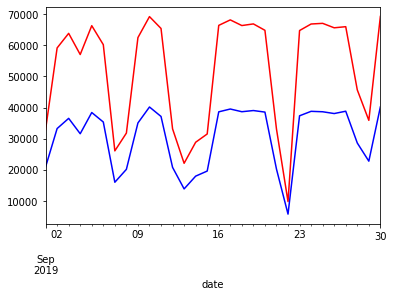

In [42]:
# 분포 파악
date['date_ride_count'].plot(color='red') # 승차량(빨강)
date['date_takeoff_count'].plot(color='blue') # 하차량(파랑)

- 일별로 승,하차량의 합을 봤을 때 승차량이 훨씬 많음.   
- 승, 하차량의 분포는 매우 비슷함   
- 주말에 승, 하차량이 급감하고, 월요일에 급증함   
- 9/22 금요일에는 왜 갑자기 저렇게 떨어진거냐? 아... 태풍왔대 미친   
- 9/12, 13, 14일(목금토) 추석 연휴 : 버스 승차량 감소    

In [62]:
# date(날짜의 특성)와 train데이터를 merge
train = pd.merge(train, date, on='date', how='left')

In [80]:
# date관련 변수 추가 : 요일, 빨간날 여부 등
# 1. 요일 구분 : 월~일 각각 0~6으로 매핑
train['week_name'] = train['date'].dt.weekday

# 빨간날 구분
def rest(x):
    if x==5|x==6:
        return 1
    else:
        return 0     
train['is_rest'] = train['week_name'].apply(rest) # 평일은 0, 토일은 1
# 추석 반영하는 코드도 있어야함 ((낼할래))

In [81]:
# 시내는 0, 시외는 1로 매핑 
train['is_inout'] = train['in_out'].map({'시외':1, '시내':0})

In [82]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,ride_count,takeoff_count,all_count,rt_dif,date_ride_count,date_takeoff_count,date_all_count,week_name,is_rest,is_inout
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,16.0,0.0,16.0,16.0,32922.0,20918.0,53840.0,6,0,1
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,22.0,0.0,22.0,22.0,32922.0,20918.0,53840.0,6,0,1
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,4.0,0.0,4.0,4.0,32922.0,20918.0,53840.0,6,0,1
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,79.0,0.0,79.0,79.0,32922.0,20918.0,53840.0,6,0,0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,1.0,1.0,-1.0,32922.0,20918.0,53840.0,6,0,0


In [79]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'ride_count', 'takeoff_count', 'all_count', 'rt_dif',
       'date_ride_count', 'date_takeoff_count', 'date_all_count', 'week_name',
       'is_rest', 'is_inout'],
      dtype='object')